## Titanic: Machine Learning from Disaster
### Import libraries

In [1]:
# Load in libraries
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

### Load data

In [2]:
train = pd.read_csv("./data/train.csv") 
test = pd.read_csv("./data/test.csv") 

passenger_id = test['PassengerId']

### Feature engineering

In [3]:
full_data = [train, test]

for dataset in full_data:
    dataset['NameLength'] = dataset['Name'].apply(len)

# NaN's type is float, C85's type is str
for dataset in full_data:
    dataset['HasCabin'] = dataset['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
# Fill all NULLs in Embarked
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# Quantile fare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
#     dataset['CategoricalFare'] = pd.qcut(dataset['Fare'], 4)
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# Generate random age for NaN age
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg-age_std, age_avg+age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it
    if title_search:
        return title_search.group(1)
    return ''

# Create feature Title which contains the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# Group all non-common titles into one single group "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                                 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
    
for dataset in full_data:
    # Mapping set
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)
    
    # Mapping titles
    dataset['Title'] = dataset['Title'].map({'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4}).astype(int)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
    # Mapping fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4
    

In [4]:
# Feature selection
train = train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'CategoricalFare'], axis=1)
test = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp'], axis=1)

In [5]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,NameLength,HasCabin,FamilySize,IsAlone,Title
0,0,3,1,1.0,0,0,0,23,0,2,0,0
1,1,1,0,2.0,0,3,1,51,1,2,0,2
2,1,3,0,1.0,0,1,0,22,0,1,1,1
3,1,1,0,2.0,0,3,0,44,1,2,0,2
4,0,3,1,2.0,0,1,0,24,0,1,1,0


### Visualizations

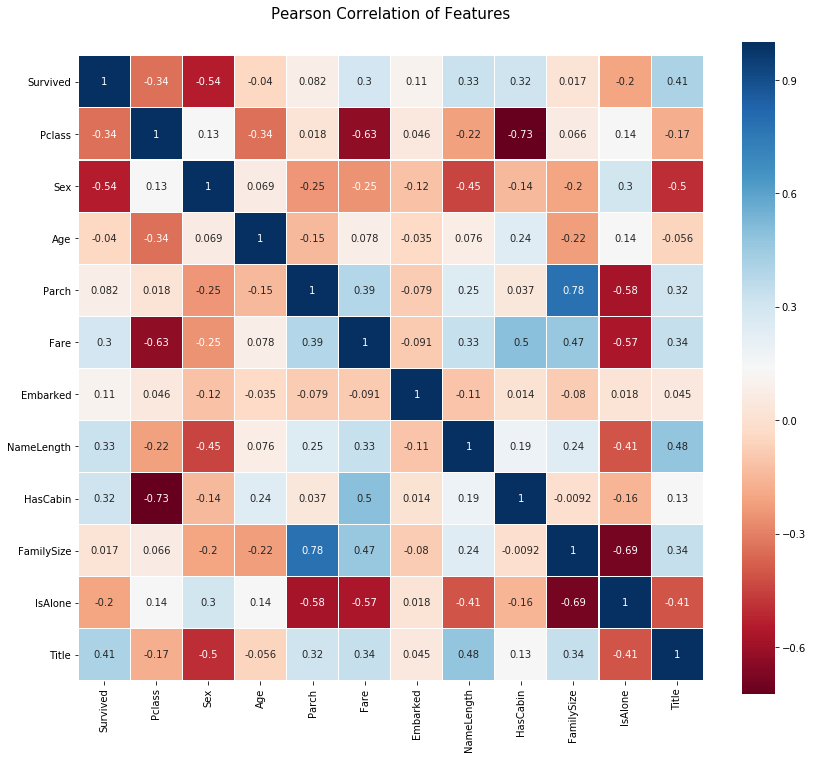

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

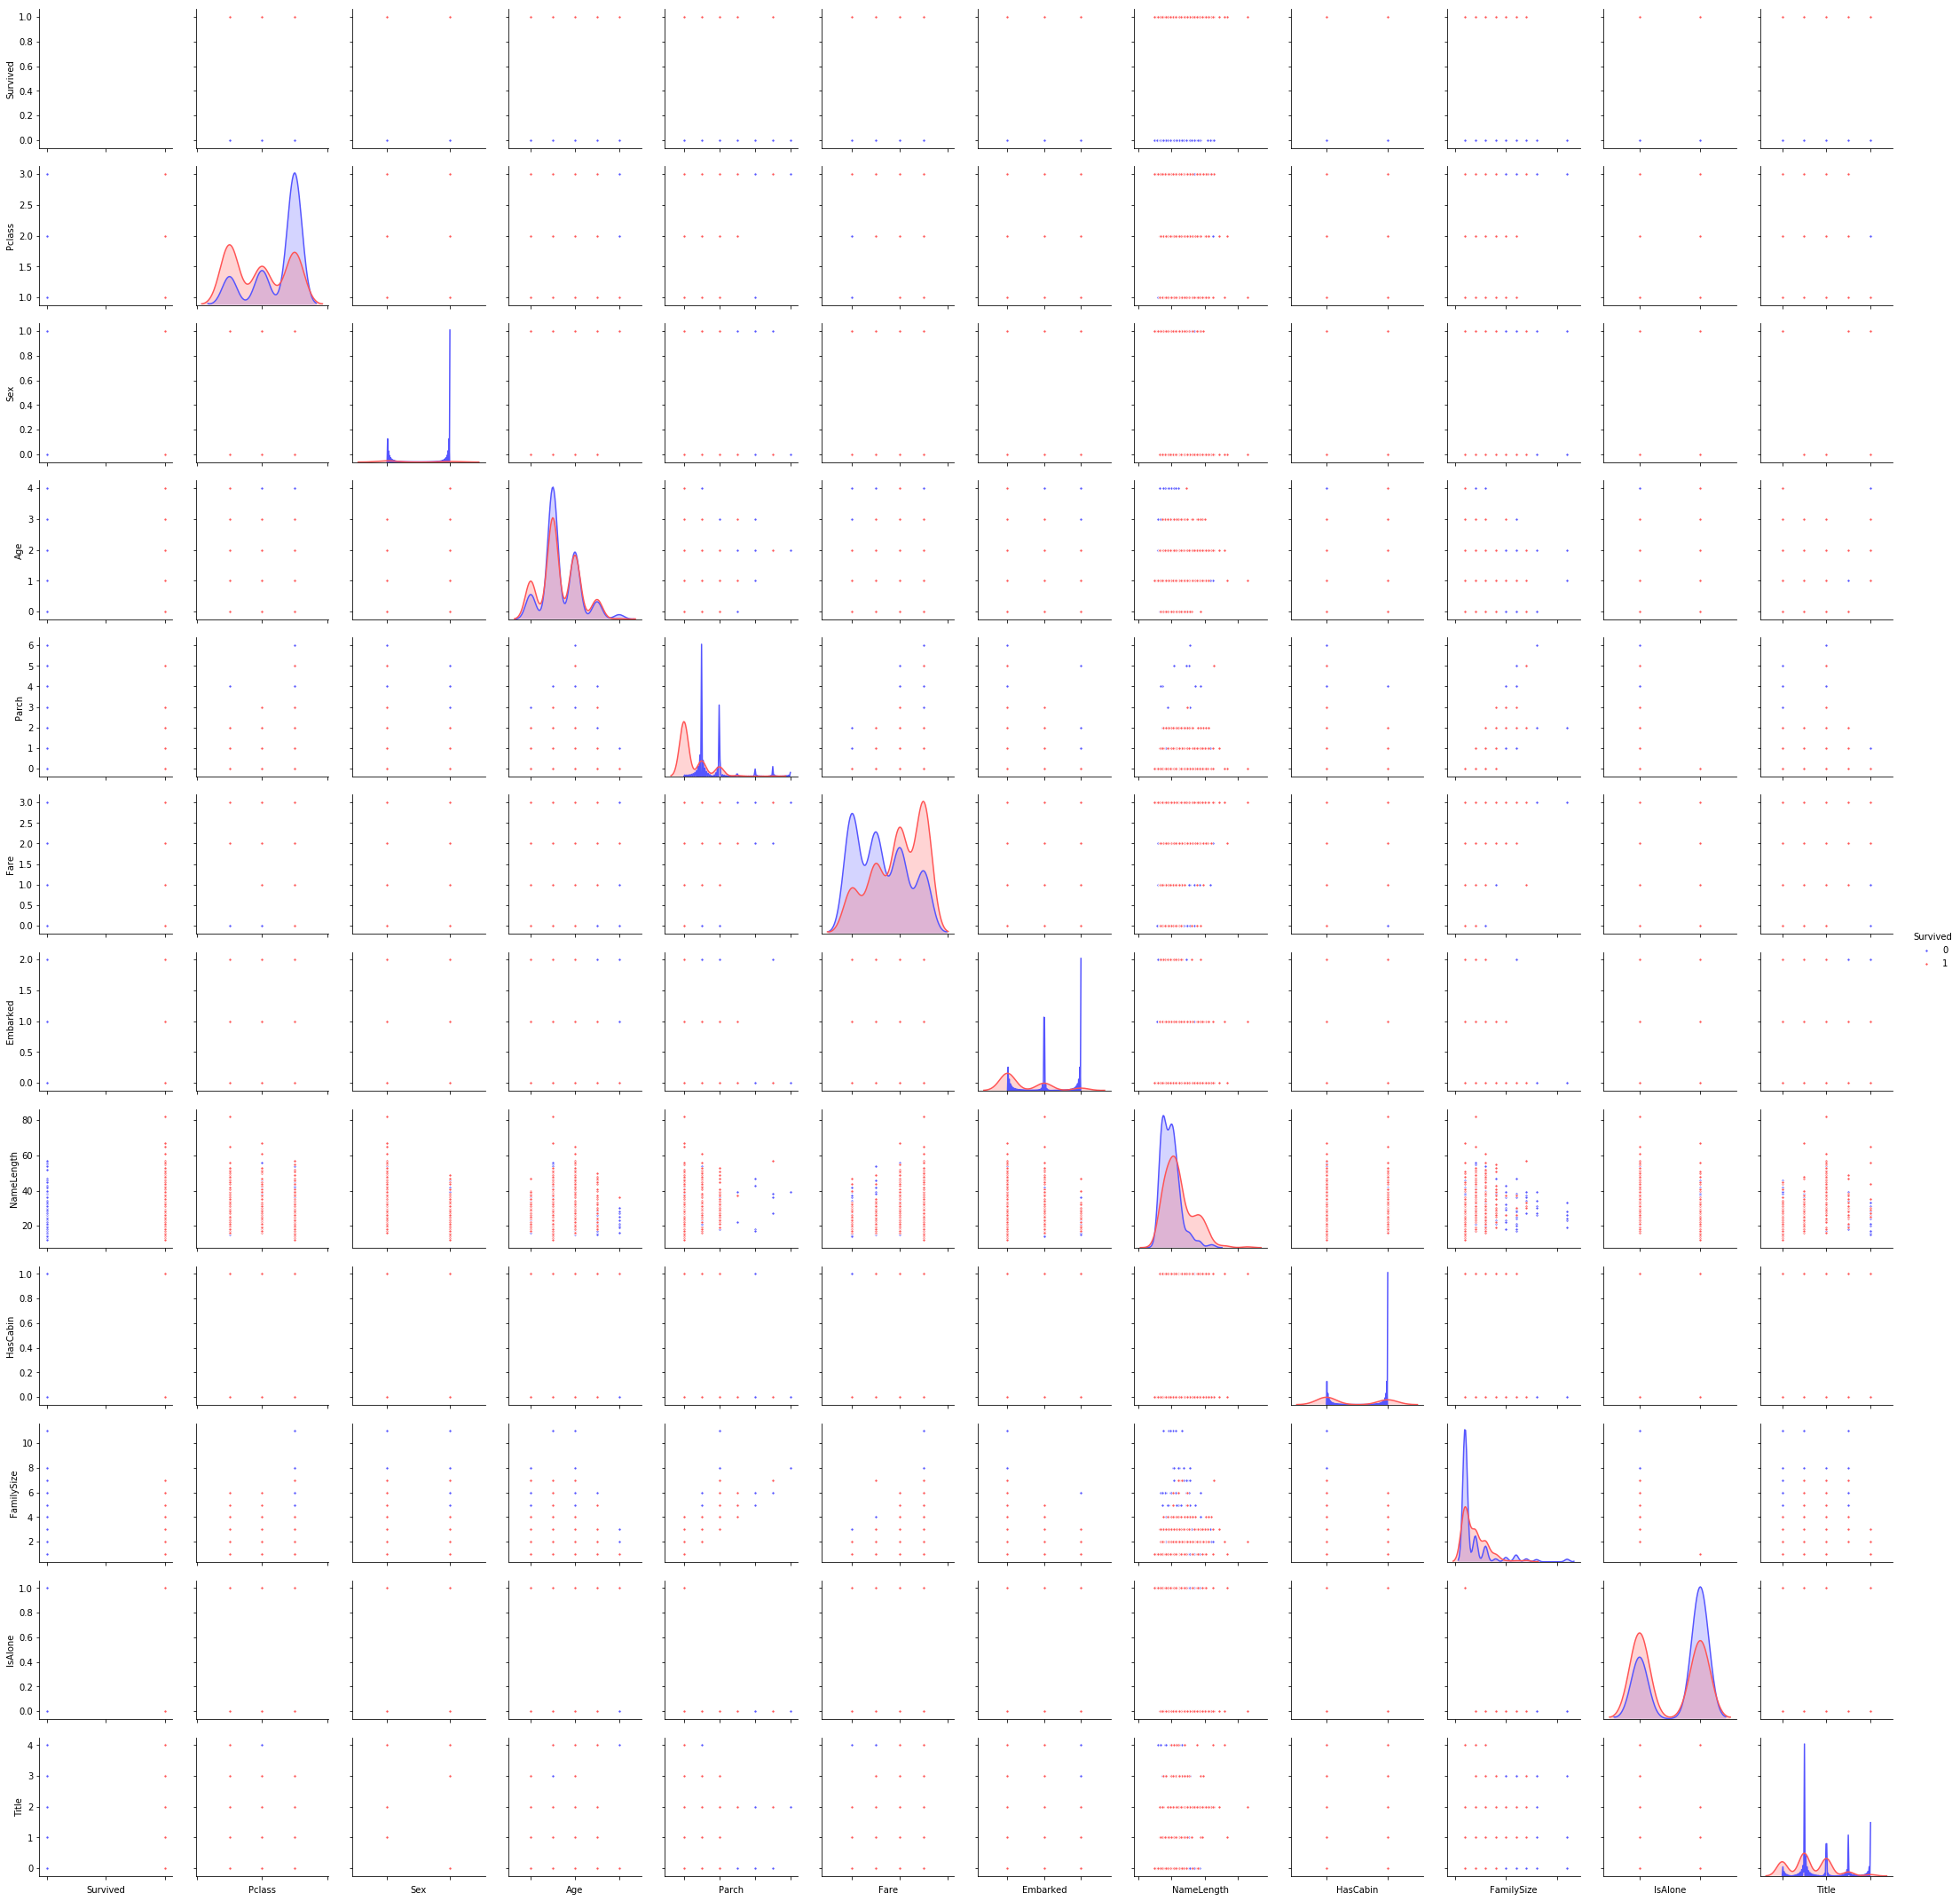

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare',
                        u'Embarked', u'NameLength', u'HasCabin', u'FamilySize',
                        u'IsAlone', u'Title']], hue='Survived', palette='seismic',
                diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

### Ensembling & Stacking models

In [8]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 1
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, random_state=SEED)

class SKlearnClassifier(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
    
    def train(self, x_train, y_train):
        self.clf = self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def feature_importances(self):
        return self.clf.feature_importances_

In [9]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain))
    oof_test = np.zeros((ntest))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    i = 0
    for train_index, valid_index in kf.split(x_train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_va = x_train[valid_index]
        
        clf.train(x_tr, y_tr)
        oof_train[valid_index] = clf.predict(x_va)
        oof_test_skf[i,:] = clf.predict(x_test)
        i += 1
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)

#### Generating first level models

In [10]:
# Define parameters

# Random Forest Parameter
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

In [11]:
rf = SKlearnClassifier(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SKlearnClassifier(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SKlearnClassifier(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SKlearnClassifier(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SKlearnClassifier(clf=SVC, seed=SEED, params=svc_params)

In [12]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values
x_test = test.values

In [13]:
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)

In [14]:
rf_features = rf.feature_importances()
et_features = et.feature_importances()
ada_features = ada.feature_importances()
gb_features = gb.feature_importances()
# Seems that svc feature imporatance is not straight forward. 
# Might be svc.clf.coef_, but it contains negative values.

In [15]:
# Define some constants
FEATURES = 'features'
RF_FI = 'Random Forest Feature Importances'
ET_FI = 'Extra Tree Feature Importances'
ADA_FI = 'AdaBoost Feature Importances'
GB_FI = 'Gradient Boost Feature Importances'
MEAN = 'Mean'

In [16]:
cols = train.columns.values
feature_df = pd.DataFrame({
    FEATURES: cols,
    RF_FI: rf_features,
    ET_FI: et_features,
    ADA_FI: ada_features,
    GB_FI: gb_features,
})
feature_df.head()

,features,Random Forest Feature Importances,Extra Tree Feature Importances,AdaBoost Feature Importances,Gradient Boost Feature Importances
0,Pclass,0.131377,0.119560,0.022,0.119211
1,Sex,0.220649,0.389499,0.002,0.007647
2,Age,0.030301,0.029846,0.018,0.051437
3,Parch,0.021141,0.016968,0.068,0.015792
4,Fare,0.072982,0.048270,0.036,0.047328


In [17]:
# Plot feature importances
def plot_feature_importances_scatter(feature_importances):
    trace = go.Scatter(
        y = feature_df[feature_importances].values,
        x = feature_df[FEATURES].values,
        mode = 'markers',
        marker = dict(
            sizemode = 'diameter',
            sizeref = 1,
            size = 25,
            color = feature_df[feature_importances].values,
            colorscale = 'Portland',
            showscale = True
        ),
        text = feature_df[FEATURES].values
    )
    data = [trace]
    layout = go.Layout(
        autosize = True,
        title = feature_importances,
        hovermode = 'closest',
        yaxis = dict(
            title = 'Feature Importances',
            ticklen = 5,
            gridwidth = 2
        ),
        showlegend = False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
    
def plot_feature_importances_bar(feature_importances):
    trace = go.Bar(
        y = feature_df[feature_importances].values,
        x = feature_df[FEATURES].values,
        marker = dict(
            color = feature_df[feature_importances].values,
            colorscale = 'Portland',
            showscale = True,
            reversescale = False
        ),
        opacity = 0.6
    )
    data = [trace]
    layout = go.Layout(
        autosize = True,
        title = feature_importances,
        hovermode = 'closest',
        yaxis = dict(
            title = 'Feature Importances',
            ticklen = 5,
            gridwidth = 2
        ),
        showlegend = False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [18]:
plot_feature_importances_scatter(RF_FI)
plot_feature_importances_scatter(ET_FI)

In [19]:
plot_feature_importances_scatter(ADA_FI)
plot_feature_importances_scatter(GB_FI)

In [20]:
feature_df[MEAN] = feature_df.mean(axis=1)
feature_df.head()

,features,Random Forest Feature Importances,Extra Tree Feature Importances,AdaBoost Feature Importances,Gradient Boost Feature Importances,Mean
0,Pclass,0.131377,0.119560,0.022,0.119211,0.098037
1,Sex,0.220649,0.389499,0.002,0.007647,0.154949
2,Age,0.030301,0.029846,0.018,0.051437,0.032396
3,Parch,0.021141,0.016968,0.068,0.015792,0.030475
4,Fare,0.072982,0.048270,0.036,0.047328,0.051145


In [21]:
plot_feature_importances_bar(MEAN)

#### Generating second level models